In [1]:
import pandas as pd
import glob
from matplotlib import pyplot
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

import warnings

In [2]:
warnings.filterwarnings("ignore")

# Read Data

In [3]:
path_files_yahoo = '../../../Documents/phd_related/data_sets_concept_drift/anomaly_detection/Yahoo_A1Benchmark'

In [4]:
filenames_yahoo = glob.glob(path_files_yahoo+"/*.csv")

In [5]:
dfs_yahoo = []
for filename in filenames_yahoo:
    dfs_yahoo.append(pd.read_csv(filename))

In [6]:
df_yahoo = pd.concat(dfs_yahoo, ignore_index=True)
#df_yahoo

<AxesSubplot:>

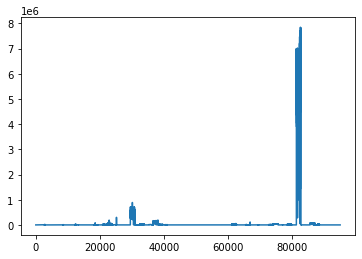

In [7]:
df_yahoo.value.plot()

# Split Train Test

We split data into 50% train and 50% test.

In [8]:
train_yahoo = df_yahoo[0:int(np.round(len(df_yahoo)/2))]
label_train = train_yahoo.is_anomaly
train_yahoo = train_yahoo.drop(['timestamp', 'is_anomaly'], axis = 1)

In [9]:
test_yahoo = df_yahoo[len(train_yahoo):]
label_test = test_yahoo.is_anomaly
test_yahoo = test_yahoo.drop(['timestamp', 'is_anomaly'], axis = 1)

In [10]:
print('Train Length', len(train_yahoo))
print('Test Length', len(test_yahoo))

Train Length 47433
Test Length 47433


# Data Preprocessing

### Train

In [11]:
scaler = MinMaxScaler()

In [12]:
train_yahoo_scale = scaler.fit_transform(np.array(train_yahoo.value).reshape(-1, 1))
#train_yahoo_scale

In [13]:
len(train_yahoo_scale)

47433

### Test

Scale testing data batches

In [14]:
len(test_yahoo)/24

1976.375

In [15]:
test_batches_yahoo = []
for i in range(0, len(test_yahoo), 24):
    test_batches_yahoo.append(scaler.transform(test_yahoo[i:i+24]))
#test_batches_yahoo

# Data Shape

In [16]:
X_train = train_yahoo_scale.reshape(train_yahoo_scale.shape[0], 1, train_yahoo_scale.shape[1])
print("Training data shape:", X_train.shape)

Training data shape: (47433, 1, 1)


### Train LSTM

This is done to reconstruct the model.

In [17]:
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
L1 = LSTM(16, activation='relu', return_sequences=True, 
        kernel_regularizer=regularizers.l2(0.00))(inputs)
L2 = LSTM(8, activation='relu', return_sequences=False)(L1)
L3 = RepeatVector(X_train.shape[1])(L2)
L4 = LSTM(8, activation='relu', return_sequences=True)(L3)
L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
output = TimeDistributed(Dense(X_train.shape[2]))(L5)    
model = Model(inputs=inputs, outputs=output)


In [18]:
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 1)]            0         
                                                                 
 lstm (LSTM)                 (None, 1, 16)             1152      
                                                                 
 lstm_1 (LSTM)               (None, 8)                 800       
                                                                 
 repeat_vector (RepeatVector  (None, 1, 8)             0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 1, 8)              544       
                                                                 
 lstm_3 (LSTM)               (None, 1, 16)             1600      
                                                             

In [19]:
no_epochs = 50
batch_size = 128
encdec = model.fit(X_train, X_train, epochs=no_epochs, batch_size=batch_size,
                    validation_split=0.25).history

Epoch 1/50
278/278 [==============================] - 4s 4ms/step - loss: 0.0243 - val_loss: 0.0200
Epoch 2/50
278/278 [==============================] - 1s 3ms/step - loss: 0.0096 - val_loss: 0.0085
Epoch 3/50
278/278 [==============================] - 1s 3ms/step - loss: 0.0034 - val_loss: 0.0036
Epoch 4/50
278/278 [==============================] - 1s 3ms/step - loss: 0.0013 - val_loss: 4.9916e-04
Epoch 5/50
278/278 [==============================] - 1s 3ms/step - loss: 6.1843e-04 - val_loss: 0.0020
Epoch 6/50
278/278 [==============================] - 1s 3ms/step - loss: 7.5487e-04 - val_loss: 1.9305e-04
Epoch 7/50
278/278 [==============================] - 1s 3ms/step - loss: 7.3410e-04 - val_loss: 2.4125e-04
Epoch 8/50
278/278 [==============================] - 1s 3ms/step - loss: 6.2043e-04 - val_loss: 0.0012
Epoch 9/50
278/278 [==============================] - 1s 3ms/step - loss: 5.8750e-04 - val_loss: 2.9315e-04
Epoch 10/50
278/278 [==============================] - 1s 3ms/st

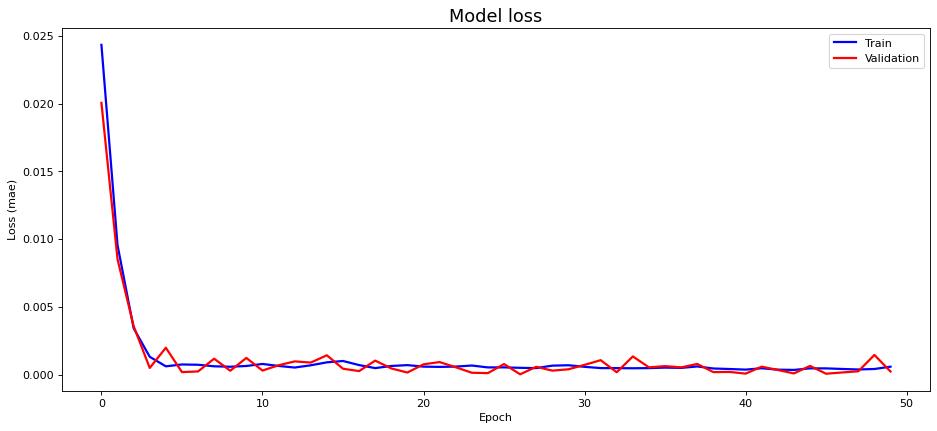

In [20]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(encdec['loss'], 'b', label='Train', linewidth=2)
ax.plot(encdec['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [21]:
#encdec['loss']

In [22]:
#encdec['val_loss']

### Anomaly Detection

Calculating the threshold that indicates an anomaly.

THRESHOLD FROM PAPER

Reconstruction error mean threshold: 0.00024500365165457843
Reconstruction error std threshold: 0.0005300568866775149


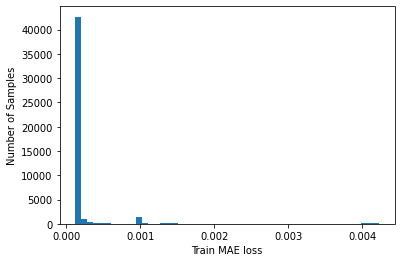

In [23]:
X_train_pred = model.predict(X_train, verbose=0)
train_mae_loss_avg = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss_avg, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

mean_threshold = np.mean(train_mae_loss_avg)
std_threshold = np.std(train_mae_loss_avg)

print(f'Reconstruction error mean threshold: {mean_threshold}')
print(f'Reconstruction error std threshold: {std_threshold}')

THRESHOLD USING MAX - it might be more accurate than mean + std because the skewness of the mae loss.

Reconstruction error Max threshold: 0.004231779436306149


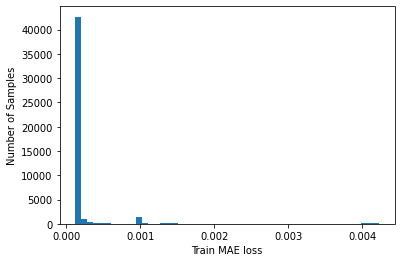

In [24]:
X_train_pred = model.predict(X_train, verbose=0)
train_mae_loss_avg = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss_avg, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

max_threshold = np.max(train_mae_loss_avg)

print(f'Reconstruction error Max threshold: {max_threshold}')

## Test Model and Extract Loss

In [25]:
test_mae_loss = []
for i in tqdm(range(0,len(test_batches_yahoo))):
    X_test_pred = model.predict(test_batches_yahoo[i], verbose=0)
    test_mae_loss.append(np.mean(np.abs(X_test_pred-test_batches_yahoo[i]), axis=1))
#test_mae_loss

100%|██████████| 1977/1977 [01:01<00:00, 32.41it/s]


### Extracting Anomalous Predicted Points

In [26]:
predicted_test_label = []
for i in tqdm(range(0, len(test_mae_loss))):
    for j in tqdm(range(0, len(test_mae_loss[i]))):
        
        # for threshold with mean + std
        #if(test_mae_loss[i][j][0]>(mean_threshold+std_threshold)):
        
        # for threshold with max
        if(test_mae_loss[i][j][0]>(max_threshold)):
            predicted_test_label.append(1)
        else:
            predicted_test_label.append(0)

100%|██████████| 24/24 [00:00<00:00, 99175.66it/s]

100%|██████████| 24/24 [00:00<00:00, 105186.31it/s]

100%|██████████| 24/24 [00:00<00:00, 115838.09it/s]

100%|██████████| 24/24 [00:00<00:00, 118846.87it/s]

100%|██████████| 24/24 [00:00<00:00, 55924.05it/s]

100%|██████████| 24/24 [00:00<00:00, 131758.24it/s]

100%|██████████| 24/24 [00:00<00:00, 254843.79it/s]

100%|██████████| 24/24 [00:00<00:00, 244922.86it/s]

100%|██████████| 24/24 [00:00<00:00, 68571.73it/s]

100%|██████████| 24/24 [00:00<00:00, 220269.79it/s]

100%|██████████| 24/24 [00:00<00:00, 186068.94it/s]

100%|██████████| 24/24 [00:00<00:00, 143599.57it/s]

100%|██████████| 24/24 [00:00<00:00, 213722.50it/s]

100%|██████████| 24/24 [00:00<00:00, 226719.14it/s]

100%|██████████| 24/24 [00:00<00:00, 129720.74it/s]

100%|██████████| 24/24 [00:00<00:00, 90933.42it/s]

100%|██████████| 24/24 [00:00<00:00, 252922.85it/s]

100%|██████████| 24/24 [00:00<00:00, 165564.63it/s]

100%|██████████| 24/24 [00:00<00:00, 136400.13it/s

100%|██████████| 24/24 [00:00<00:00, 332222.10it/s]

100%|██████████| 24/24 [00:00<00:00, 399457.52it/s]

100%|██████████| 24/24 [00:00<00:00, 208845.01it/s]

100%|██████████| 24/24 [00:00<00:00, 181702.70it/s]

100%|██████████| 24/24 [00:00<00:00, 356962.04it/s]

100%|██████████| 24/24 [00:00<00:00, 394758.02it/s]

100%|██████████| 24/24 [00:00<00:00, 285165.14it/s]

100%|██████████| 24/24 [00:00<00:00, 381300.36it/s]

100%|██████████| 24/24 [00:00<00:00, 208412.62it/s]

100%|██████████| 24/24 [00:00<00:00, 363405.40it/s]

100%|██████████| 24/24 [00:00<00:00, 374213.00it/s]

100%|██████████| 24/24 [00:00<00:00, 381300.36it/s]

100%|██████████| 24/24 [00:00<00:00, 249784.85it/s]

100%|██████████| 24/24 [00:00<00:00, 273541.57it/s]

100%|██████████| 24/24 [00:00<00:00, 353204.55it/s]

100%|██████████| 24/24 [00:00<00:00, 388661.37it/s]

100%|██████████| 24/24 [00:00<00:00, 336666.54it/s]

100%|██████████| 24/24 [00:00<00:00, 342392.16it/s]

100%|██████████| 24/24 [00:00<00:00, 363405.40

100%|██████████| 24/24 [00:00<00:00, 285975.27it/s]

100%|██████████| 24/24 [00:00<00:00, 319566.02it/s]

100%|██████████| 24/24 [00:00<00:00, 134039.01it/s]

100%|██████████| 24/24 [00:00<00:00, 285975.27it/s]

100%|██████████| 24/24 [00:00<00:00, 320583.75it/s]

100%|██████████| 24/24 [00:00<00:00, 312618.93it/s]

100%|██████████| 24/24 [00:00<00:00, 163414.44it/s]

100%|██████████| 24/24 [00:00<00:00, 279620.27it/s]

100%|██████████| 24/24 [00:00<00:00, 249784.85it/s]

100%|██████████| 24/24 [00:00<00:00, 291777.67it/s]

100%|██████████| 24/24 [00:00<00:00, 159025.74it/s]

100%|██████████| 24/24 [00:00<00:00, 282762.07it/s]

100%|██████████| 24/24 [00:00<00:00, 128890.26it/s]

100%|██████████| 24/24 [00:00<00:00, 278845.70it/s]

100%|██████████| 24/24 [00:00<00:00, 196608.00it/s]

100%|██████████| 24/24 [00:00<00:00, 86332.16it/s]

100%|██████████| 24/24 [00:00<00:00, 128890.26it/s]

100%|██████████| 24/24 [00:00<00:00, 260785.74it/s]

100%|██████████| 24/24 [00:00<00:00, 172664.32i

100%|██████████| 24/24 [00:00<00:00, 239674.51it/s]

100%|██████████| 24/24 [00:00<00:00, 252922.85it/s]

100%|██████████| 24/24 [00:00<00:00, 285975.27it/s]

100%|██████████| 24/24 [00:00<00:00, 272800.26it/s]

100%|██████████| 24/24 [00:00<00:00, 142987.64it/s]

100%|██████████| 24/24 [00:00<00:00, 207126.12it/s]

100%|██████████| 24/24 [00:00<00:00, 141979.26it/s]

100%|██████████| 24/24 [00:00<00:00, 250406.21it/s]

100%|██████████| 24/24 [00:00<00:00, 127745.30it/s]

100%|██████████| 24/24 [00:00<00:00, 267721.53it/s]

100%|██████████| 24/24 [00:00<00:00, 84876.30it/s]

100%|██████████| 24/24 [00:00<00:00, 252288.96it/s]

100%|██████████| 24/24 [00:00<00:00, 72263.67it/s]

100%|██████████| 24/24 [00:00<00:00, 125672.03it/s]

100%|██████████| 24/24 [00:00<00:00, 90606.03it/s]

100%|██████████| 24/24 [00:00<00:00, 111107.39it/s]

100%|██████████| 24/24 [00:00<00:00, 102092.59it/s]

100%|██████████| 24/24 [00:00<00:00, 121721.04it/s]

100%|██████████| 24/24 [00:00<00:00, 117734.85it/

100%|██████████| 24/24 [00:00<00:00, 260785.74it/s]

100%|██████████| 24/24 [00:00<00:00, 80854.05it/s]

100%|██████████| 24/24 [00:00<00:00, 127745.30it/s]

100%|██████████| 24/24 [00:00<00:00, 247329.97it/s]

100%|██████████| 24/24 [00:00<00:00, 200125.84it/s]

100%|██████████| 24/24 [00:00<00:00, 146525.90it/s]

100%|██████████| 24/24 [00:00<00:00, 247329.97it/s]

100%|██████████| 24/24 [00:00<00:00, 260785.74it/s]

100%|██████████| 24/24 [00:00<00:00, 240246.53it/s]

100%|██████████| 24/24 [00:00<00:00, 289262.34it/s]

100%|██████████| 24/24 [00:00<00:00, 226719.14it/s]

100%|██████████| 24/24 [00:00<00:00, 121135.13it/s]

100%|██████████| 24/24 [00:00<00:00, 260785.74it/s]

100%|██████████| 24/24 [00:00<00:00, 291777.67it/s]

100%|██████████| 24/24 [00:00<00:00, 279620.27it/s]

100%|██████████| 24/24 [00:00<00:00, 275036.33it/s]

100%|██████████| 24/24 [00:00<00:00, 272800.26it/s]

100%|██████████| 24/24 [00:00<00:00, 165292.77it/s]

100%|██████████| 24/24 [00:00<00:00, 141979.26i

100%|██████████| 24/24 [00:00<00:00, 328965.02it/s]

100%|██████████| 24/24 [00:00<00:00, 272800.26it/s]

100%|██████████| 24/24 [00:00<00:00, 289262.34it/s]

100%|██████████| 24/24 [00:00<00:00, 112724.86it/s]

100%|██████████| 24/24 [00:00<00:00, 312618.93it/s]

100%|██████████| 24/24 [00:00<00:00, 93034.47it/s]

100%|██████████| 24/24 [00:00<00:00, 90933.42it/s]

100%|██████████| 24/24 [00:00<00:00, 134217.73it/s]

100%|██████████| 24/24 [00:00<00:00, 110619.01it/s]

100%|██████████| 24/24 [00:00<00:00, 244922.86it/s]

100%|██████████| 24/24 [00:00<00:00, 252922.85it/s]

100%|██████████| 24/24 [00:00<00:00, 123060.26it/s]

100%|██████████| 24/24 [00:00<00:00, 273541.57it/s]

100%|██████████| 24/24 [00:00<00:00, 74510.21it/s]

100%|██████████| 24/24 [00:00<00:00, 239674.51it/s]

100%|██████████| 24/24 [00:00<00:00, 273541.57it/s]

100%|██████████| 24/24 [00:00<00:00, 266305.02it/s]

100%|██████████| 24/24 [00:00<00:00, 161061.27it/s]

100%|██████████| 24/24 [00:00<00:00, 112598.77it/

100%|██████████| 24/24 [00:00<00:00, 228780.22it/s]

100%|██████████| 24/24 [00:00<00:00, 304118.72it/s]

100%|██████████| 24/24 [00:00<00:00, 100062.92it/s]

100%|██████████| 24/24 [00:00<00:00, 285975.27it/s]

100%|██████████| 24/24 [00:00<00:00, 109060.99it/s]

100%|██████████| 24/24 [00:00<00:00, 201326.59it/s]

100%|██████████| 24/24 [00:00<00:00, 278845.70it/s]

100%|██████████| 24/24 [00:00<00:00, 146312.93it/s]

100%|██████████| 24/24 [00:00<00:00, 304118.72it/s]

100%|██████████| 24/24 [00:00<00:00, 121721.04it/s]

100%|██████████| 24/24 [00:00<00:00, 249784.85it/s]

100%|██████████| 24/24 [00:00<00:00, 282762.07it/s]

100%|██████████| 24/24 [00:00<00:00, 166661.09it/s]

100%|██████████| 24/24 [00:00<00:00, 273541.57it/s]

100%|██████████| 24/24 [00:00<00:00, 102092.59it/s]

100%|██████████| 24/24 [00:00<00:00, 156796.41it/s]

100%|██████████| 24/24 [00:00<00:00, 282762.07it/s]

100%|██████████| 24/24 [00:00<00:00, 129055.51it/s]

100%|██████████| 24/24 [00:00<00:00, 249784.85

100%|██████████| 24/24 [00:00<00:00, 176292.99it/s]

100%|██████████| 24/24 [00:00<00:00, 279620.27it/s]

100%|██████████| 24/24 [00:00<00:00, 285975.27it/s]

100%|██████████| 24/24 [00:00<00:00, 306900.29it/s]

100%|██████████| 24/24 [00:00<00:00, 275789.85it/s]

100%|██████████| 24/24 [00:00<00:00, 61984.79it/s]

100%|██████████| 24/24 [00:00<00:00, 201730.05it/s]

100%|██████████| 24/24 [00:00<00:00, 42762.66it/s]

100%|██████████| 24/24 [00:00<00:00, 41960.52it/s]

100%|██████████| 24/24 [00:00<00:00, 46581.81it/s]

100%|██████████| 24/24 [00:00<00:00, 44938.97it/s]

100%|██████████| 24/24 [00:00<00:00, 31447.45it/s]

100%|██████████| 24/24 [00:00<00:00, 42048.16it/s]

100%|██████████| 24/24 [00:00<00:00, 148910.20it/s]

100%|██████████| 24/24 [00:00<00:00, 165292.77it/s]

100%|██████████| 24/24 [00:00<00:00, 6367.87it/s]

100%|██████████| 24/24 [00:00<00:00, 20112.55it/s]

100%|██████████| 24/24 [00:00<00:00, 235194.62it/s]

100%|██████████| 24/24 [00:00<00:00, 258111.02it/s]

100

100%|██████████| 24/24 [00:00<00:00, 304118.72it/s]

100%|██████████| 24/24 [00:00<00:00, 280399.15it/s]

100%|██████████| 24/24 [00:00<00:00, 164482.51it/s]

100%|██████████| 24/24 [00:00<00:00, 333322.17it/s]

100%|██████████| 24/24 [00:00<00:00, 336666.54it/s]

100%|██████████| 24/24 [00:00<00:00, 307838.83it/s]

100%|██████████| 24/24 [00:00<00:00, 288433.51it/s]

100%|██████████| 24/24 [00:00<00:00, 226209.65it/s]

100%|██████████| 24/24 [00:00<00:00, 178165.13it/s]

100%|██████████| 24/24 [00:00<00:00, 328965.02it/s]

100%|██████████| 24/24 [00:00<00:00, 319566.02it/s]

100%|██████████| 24/24 [00:00<00:00, 319566.02it/s]

100%|██████████| 24/24 [00:00<00:00, 130392.87it/s]

100%|██████████| 24/24 [00:00<00:00, 278845.70it/s]

100%|██████████| 24/24 [00:00<00:00, 141979.26it/s]

100%|██████████| 24/24 [00:00<00:00, 278845.70it/s]

100%|██████████| 24/24 [00:00<00:00, 164482.51it/s]

100%|██████████| 24/24 [00:00<00:00, 100764.06it/s]

100%|██████████| 24/24 [00:00<00:00, 269153.20

100%|██████████| 24/24 [00:00<00:00, 358232.37it/s]

100%|██████████| 24/24 [00:00<00:00, 415964.03it/s]

100%|██████████| 24/24 [00:00<00:00, 358232.37it/s]

100%|██████████| 24/24 [00:00<00:00, 156796.41it/s]

100%|██████████| 24/24 [00:00<00:00, 393216.00it/s]

100%|██████████| 24/24 [00:00<00:00, 385683.13it/s]

100%|██████████| 24/24 [00:00<00:00, 148252.28it/s]

100%|██████████| 24/24 [00:00<00:00, 379861.49it/s]

100%|██████████| 24/24 [00:00<00:00, 399457.52it/s]

100%|██████████| 24/24 [00:00<00:00, 244922.86it/s]

100%|██████████| 24/24 [00:00<00:00, 161061.27it/s]

100%|██████████| 24/24 [00:00<00:00, 348315.90it/s]

100%|██████████| 24/24 [00:00<00:00, 351969.57it/s]

100%|██████████| 24/24 [00:00<00:00, 412554.49it/s]

100%|██████████| 24/24 [00:00<00:00, 123210.89it/s]

100%|██████████| 24/24 [00:00<00:00, 387166.52it/s]

100%|██████████| 24/24 [00:00<00:00, 393216.00it/s]

100%|██████████| 24/24 [00:00<00:00, 362098.19it/s]

100%|██████████| 24/24 [00:00<00:00, 205016.90

100%|██████████| 24/24 [00:00<00:00, 320583.75it/s]

100%|██████████| 24/24 [00:00<00:00, 315558.92it/s]

100%|██████████| 24/24 [00:00<00:00, 320583.75it/s]

100%|██████████| 24/24 [00:00<00:00, 405900.39it/s]

100%|██████████| 24/24 [00:00<00:00, 311651.07it/s]

100%|██████████| 24/24 [00:00<00:00, 393216.00it/s]

100%|██████████| 24/24 [00:00<00:00, 347114.81it/s]

100%|██████████| 24/24 [00:00<00:00, 379861.49it/s]

100%|██████████| 24/24 [00:00<00:00, 394758.02it/s]

100%|██████████| 24/24 [00:00<00:00, 159025.74it/s]

100%|██████████| 24/24 [00:00<00:00, 363405.40it/s]

100%|██████████| 24/24 [00:00<00:00, 207126.12it/s]

100%|██████████| 24/24 [00:00<00:00, 394758.02it/s]

100%|██████████| 24/24 [00:00<00:00, 351969.57it/s]

100%|██████████| 24/24 [00:00<00:00, 342392.16it/s]

100%|██████████| 24/24 [00:00<00:00, 182031.28it/s]

100%|██████████| 24/24 [00:00<00:00, 387166.52it/s]

100%|██████████| 24/24 [00:00<00:00, 407543.71it/s]

100%|██████████| 24/24 [00:00<00:00, 363405.40

100%|██████████| 24/24 [00:00<00:00, 328965.02it/s]

100%|██████████| 24/24 [00:00<00:00, 323676.19it/s]

100%|██████████| 24/24 [00:00<00:00, 206700.81it/s]

100%|██████████| 24/24 [00:00<00:00, 216015.66it/s]

100%|██████████| 24/24 [00:00<00:00, 214177.23it/s]

100%|██████████| 24/24 [00:00<00:00, 206700.81it/s]

100%|██████████| 24/24 [00:00<00:00, 205435.30it/s]

100%|██████████| 24/24 [00:00<00:00, 173857.16it/s]

100%|██████████| 24/24 [00:00<00:00, 397878.64it/s]

100%|██████████| 24/24 [00:00<00:00, 421185.34it/s]

100%|██████████| 24/24 [00:00<00:00, 159025.74it/s]

100%|██████████| 24/24 [00:00<00:00, 359511.77it/s]

100%|██████████| 24/24 [00:00<00:00, 219788.86it/s]

100%|██████████| 24/24 [00:00<00:00, 220269.79it/s]

100%|██████████| 24/24 [00:00<00:00, 203360.19it/s]

100%|██████████| 24/24 [00:00<00:00, 212369.82it/s]

100%|██████████| 24/24 [00:00<00:00, 224194.42it/s]

100%|██████████| 24/24 [00:00<00:00, 226209.65it/s]

100%|██████████| 24/24 [00:00<00:00, 226209.65

In [27]:
f1_score(label_test, predicted_test_label, average='weighted')

0.9008890508804649

In [28]:
f1_score(label_test, predicted_test_label, average='macro')

0.4782204414103409

In [29]:
f1_score(label_test, predicted_test_label, average='micro')

0.8505260051019331

In [30]:
precision_score(label_test, predicted_test_label, average='weighted')

0.9600010107670227

In [31]:
precision_score(label_test, predicted_test_label, average='macro')

0.5006200529544833

In [32]:
precision_score(label_test, predicted_test_label, average='micro')

0.8505260051019332

In [33]:
recall_score(label_test, predicted_test_label, average='weighted')

0.8505260051019332

In [34]:
recall_score(label_test, predicted_test_label, average='macro')

0.5035987260864698

In [35]:
recall_score(label_test, predicted_test_label, average='micro')

0.8505260051019332

## Save Results

In [36]:
df_results = pd.DataFrame()

In [37]:
df_results['true_labels'] = label_test
df_results['lstmae_static_labels'] = predicted_test_label

In [38]:
df_results[(df_results.true_labels == 1) & (df_results.lstmae_static_labels == 1)]

,true_labels,lstmae_static_labels
61694,1,1
62113,1,1
62336,1,1
62337,1,1
62338,1,1
...,...,...
86735,1,1
86834,1,1
87918,1,1
88021,1,1


In [39]:
df_results.to_csv('./results/predictions_real_labels.csv')

# Plot Anomalies in Test

In [40]:
test_mae_loss_plot = []
for i in range(0, len(test_batches_yahoo)):
    for j in range(0, len(test_batches_yahoo[i])):
        test_mae_loss_plot.append(test_batches_yahoo[i][j][0])
#test_mae_loss_plot

In [41]:
#[i for i,v in enumerate(test_mae_loss_plot) if v > max_threshold]

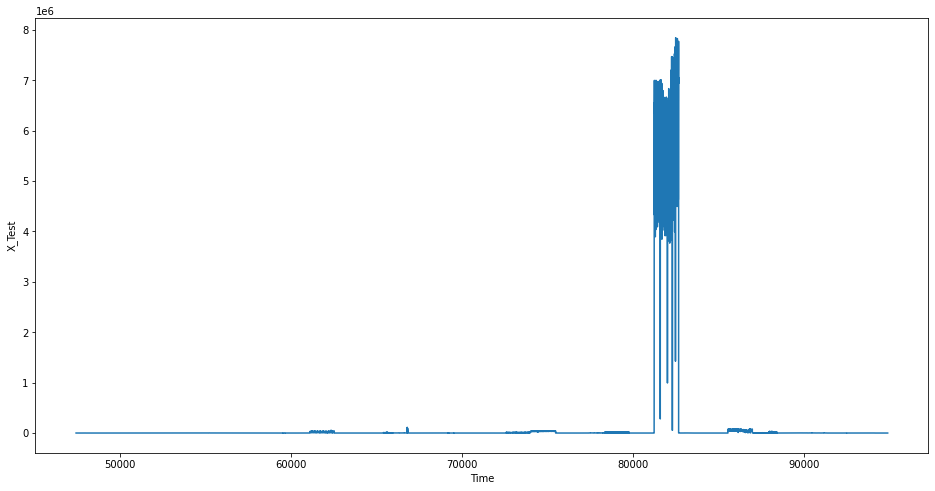

In [42]:
plt.figure(figsize=(16,8))
plt.plot(test_yahoo)
plt.xlabel('Time')
plt.ylabel('X_Test');

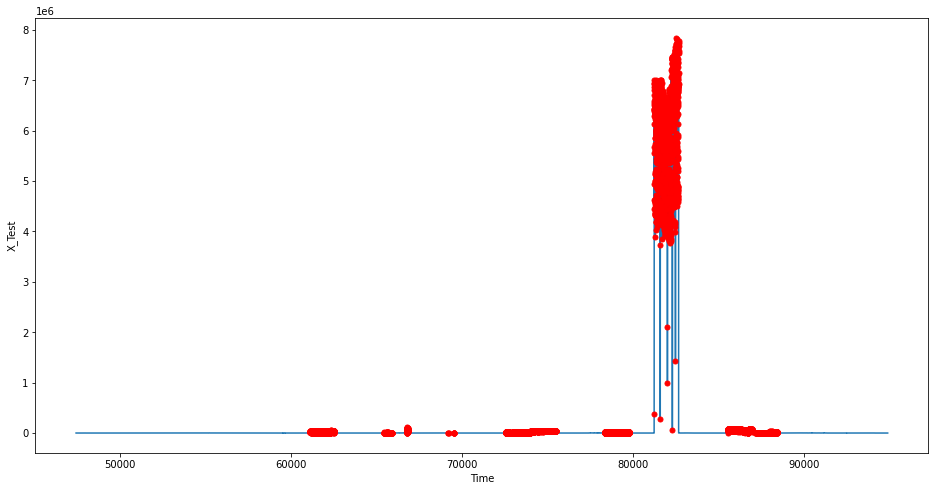

In [43]:
markers_on = [i for i,v in enumerate(test_mae_loss_plot) if v > max_threshold]
plt.figure(figsize=(16,8))
plt.plot(test_yahoo, markevery=markers_on, marker = 'o', mec = 'r', mfc = 'r', ms = 5)
plt.xlabel('Time')
plt.ylabel('X_Test');